<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22MNIST(CNN%2C_Lesson)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2023-07-04 08:39:41--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  52.2MB/s    in 2.0s    

2023-07-04 08:39:43 (52.2 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2023-07-04 08:39:43--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  32.5MB/s    in 0.5s    

2023-07-04 08:39:44 (32.5 MB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = np.genfromtxt('mnist_test.csv',delimiter=',',skip_header=1)

In [5]:
x = data[:,1:]

In [6]:
x = x.reshape(-1, 1, 28, 28)

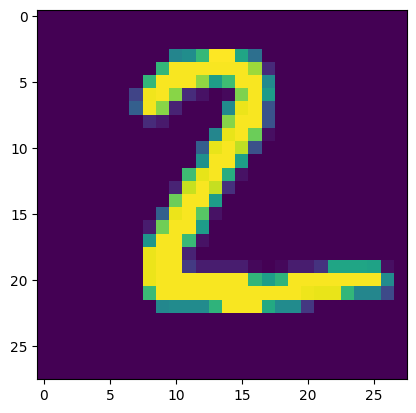

In [7]:
plt.imshow(x[0][0])

In [8]:
class MNISTDataset(Dataset):

  def __init__(self, path):
    data = np.genfromtxt(path, delimiter=',',skip_header=1,dtype=np.float32)
    self.features = torch.from_numpy(data[:,1:]).reshape(-1, 1, 28, 28)
    # int for cross entryp loss
    self.labels = torch.from_numpy(data[:,0].astype(int))
    self.n_samples = data.shape[0]
  def __getitem__(self,index):
    return self.features[index]/255, self.labels[index]
  def __len__(self):
    return self.n_samples

In [9]:
training_data = MNISTDataset('mnist_train.csv')
test_data = MNISTDataset('mnist_test.csv')

In [10]:
data = next(iter(test_data))

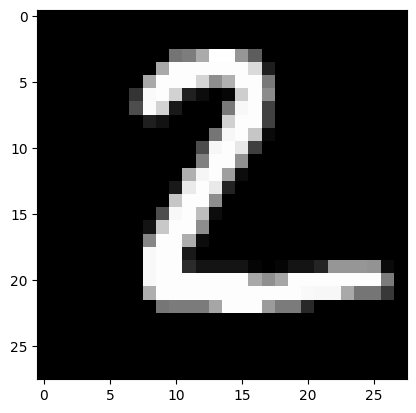

In [11]:
plt.imshow(data[0][0], cmap='gray')
plt.show()

In [12]:
data[1]

tensor(2)

In [13]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [14]:
# MNIST Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(24*24*9,10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = nn.functional.log_softmax(x,dim=1)
        return x

In [15]:
24*24*9

5184

In [16]:
x = torch.zeros((1,28,28))

In [17]:
conv = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(5,5))

In [18]:
out = conv(x)

In [19]:
out.shape

torch.Size([64, 24, 24])

In [20]:
model = SimpleCNN()

In [21]:
summary(model,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

In [22]:
# loss and optimizer
learning_rate = 0.001
# Binary Cross Entropy between the target and the output:
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [23]:
num_epochs = 5
total_step = len(train_dataloader)

In [24]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(self.train_dataloader):

            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(self.test_dataloader):

            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [25]:
trainer = Trainer(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    criterion=criterion,
    optimizer=optimizer
)

In [26]:
trainer.train()

Epoch[1/5] 	 train_loss: 0.36427, train_acc: 0.90 	 val_loss: 0.29445 	 val_acc: 0.92
Epoch[2/5] 	 train_loss: 0.30008, train_acc: 0.92 	 val_loss: 0.28518 	 val_acc: 0.92
Epoch[3/5] 	 train_loss: 0.28898, train_acc: 0.92 	 val_loss: 0.27747 	 val_acc: 0.92
Epoch[4/5] 	 train_loss: 0.28201, train_acc: 0.92 	 val_loss: 0.28551 	 val_acc: 0.92
Epoch[5/5] 	 train_loss: 0.27575, train_acc: 0.92 	 val_loss: 0.27643 	 val_acc: 0.92


In [27]:
history = trainer.history

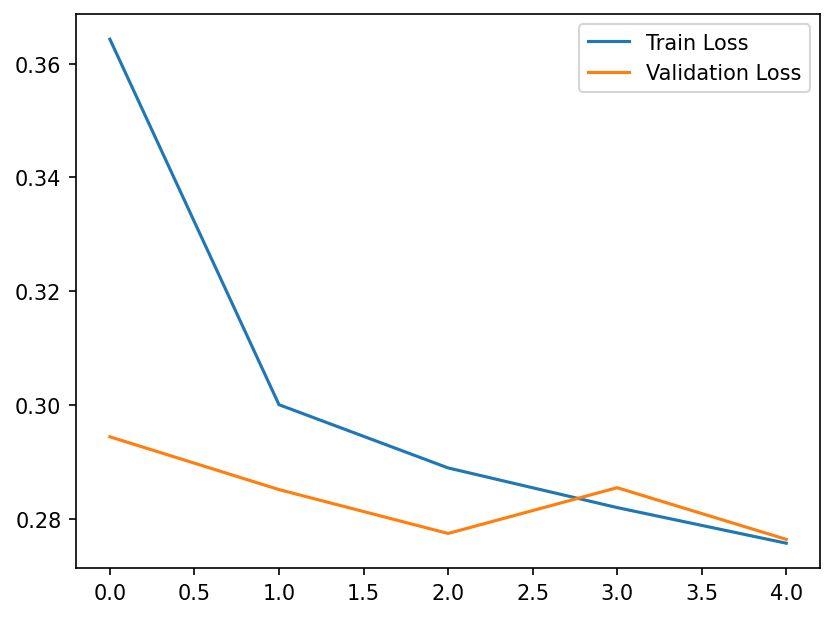

In [28]:
plt.figure(dpi=150)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()